# <br><span style="color:teal"> <center>DQN for Atari Enduro-v0 </center> </span>
Team members : <ul>
    <li> Laurie Fernandez </li>
    <li> Hiba Khayati </li>
</ul>

# <span style="color:teal"> What is DQN ? </span>
A DQN, or Deep Q-Network, approximates a state-value function in a Q-Learning framework with a neural network. In the Atari Games case, they take in several frames of the game as an input and output state values for each action as an output.
# <span style="color:teal"> Why using DQN ? </span>
DQN is proved to be one of the best methods to train an AI for several Atari games, Enduro is one of the games listed as really efficient using a DQN method. 

### Import Required Packages

In [1]:
from time import sleep
from __future__ import division

import gym
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, concatenate, Permute
from keras.layers import Input, Conv2D
from keras.optimizers import Adam
from keras.activations import relu, linear
from keras.layers.advanced_activations import LeakyReLU

from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor

Using TensorFlow backend.


***
### RoadRunner Environment

In [2]:
env = gym.make('Enduro-v0')

env.render()
sleep(1)
env.close()

#### 1. *Number of possible action*
There are 9 possible actions in the Enduro game, not to do anything, move forward, move left or move right. The other possible actions are combinations of the ones cited before.

In [3]:
nb_actions = env.action_space.n
print('Total number of Possible actoin is :', nb_actions)

Total number of Possible actoin is : 9


#### 2. *Taking stack of 4 consecutive frames*

In [4]:
frame_shape = (84, 84)
window_length = 4
input_shape = (window_length,) + frame_shape
print('Input Shape is :', input_shape)

Input Shape is : (4, 84, 84)


***
### Defining class for pre-processing the game_frames

In [5]:
class GameProcess(Processor):
    def process_observation(self, observation):
        img = Image.fromarray(observation)
        img = np.array(img.resize(frame_shape).convert('L'))
        return img.astype('uint8')  

    def process_state_batch(self, batch):
        Processed_batch = batch.astype('float32') / 255.
        return Processed_batch

    def process_reward(self, reward):
        return np.clip(reward, -1., 1.)

***
## DeepMind Architecture

In [6]:
model = Sequential()
model.add(Permute((2, 3, 1), input_shape=input_shape))
model.add(Conv2D(32, (8, 8), strides=(4, 4)))
model.add(Activation('relu'))
model.add(Conv2D(64, (4, 4), strides=(2, 2)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), strides=(1, 1)))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_1 (Permute)          (None, 84, 84, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 32)        8224      
_________________________________________________________________
activation_1 (Activation)    (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          32832     
_________________________________________________________________
activation_2 (Activation)    (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
activation_3 (Activation)    (None, 7, 7, 64)          0         
__________

***
### Configuring the Agent

#### 1. *Allocating memory for experience replay*

In [7]:
memory = SequentialMemory(limit=1000000, window_length=window_length)

#### 2.* Policy: Epsilon Greedy Exploration*
<span style="color:teal">*Gradually exploration will be decreased*</span>

In [8]:
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.05, nb_steps=1000000)

#### 3. *Compiling DQN Agent*

In [9]:
dqn = DQNAgent(model=model, nb_actions=nb_actions, policy=policy, memory=memory, processor=GameProcess(),
               nb_steps_warmup=50000, gamma=.99, target_model_update=10000, train_interval=4, delta_clip=1.)

In [10]:
dqn.compile(Adam(lr=.00025), metrics=['mae'])

***
## <span style="color:teal"> Training the model </span>

#### 1. *Check if Agent is learning for first 0.5M Steps*

In [11]:
history = dqn.fit(env, nb_steps=500000)

Training for 500000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 50s - reward: 0.0000e+00    - ETA: 0s - 
2 episodes - episode_reward: 0.000 [0.000, 0.000] - ale.lives: 0.000

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 48s - reward: 0.0000e+00    
2 episodes - episode_reward: 0.000 [0.000, 0.000] - ale.lives: 0.000

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 47s - reward: 0.0000e+00    
2 episodes - episode_reward: 0.000 [0.000, 0.000] - ale.lives: 0.000

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 48s - reward: 0.0000e+00    - ETA: 0s - rew - ETA: 0s - rewa
3 episodes - episode_reward: 0.000 [0.000, 0.000] - ale.lives: 0.000

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 50s - reward: 0.0000e+00    
2 episodes - episode_reward: 0.000 [0.000, 0.000] - ale.lives: 0.000

Interval 6 (50000 steps p

#### 2. *Summarizing the training history*

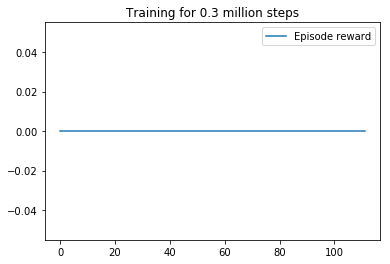

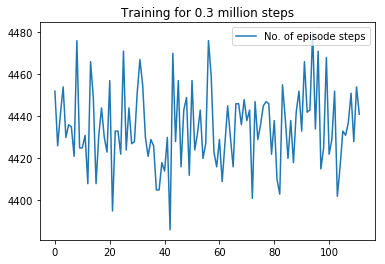

In [19]:
plt.plot(history.history['episode_reward'])
plt.title('Training for 0.3 million steps')
plt.legend(['Episode reward'], loc='upper right')
plt.show()

plt.plot(history.history['nb_episode_steps'])
plt.title('Training for 0.3 million steps')
plt.legend(['No. of episode steps'], loc='upper right')
plt.show()

#### 3. *Saving the weights*
Here, we save the weights of the 500000 steps done in order to have a more accurate idea of the real weights we have to attribute to steps.

In [13]:
dqn.save_weights('dqn_atari_Enduro.h5f', overwrite=True)

### <span style="color:red">**-  -  Caution   -  -**</span>

### <span style="color:teal">Re-Training the model (for 2M steps)  </span>
*Loading the saved weights (of 0.5M steps)*
This second training based on more accurate weights and on a bigger number of steps will permit us

In [14]:
dqn.load_weights('dqn_atari_Enduro.h5f')

In [15]:
dqn = DQNAgent(model=model, nb_actions=nb_actions, policy=policy, memory=memory, processor=GameProcess(),
               gamma=.99, target_model_update=10000, train_interval=4, delta_clip=1.)

dqn.compile(Adam(lr=0.00025), metrics=['mae'])

In [16]:
history2M = dqn.fit(env, nb_steps=2000000)

Training for 2000000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 175s - reward: 0.0000e+00   
2 episodes - episode_reward: 0.000 [0.000, 0.000] - loss: 0.000 - mean_absolute_error: 0.012 - mean_q: 0.014 - mean_eps: 0.995 - ale.lives: 0.000

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 186s - reward: 0.0000e+00   
2 episodes - episode_reward: 0.000 [0.000, 0.000] - loss: 0.000 - mean_absolute_error: 0.012 - mean_q: 0.014 - mean_eps: 0.987 - ale.lives: 0.000

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 186s - reward: 0.0000e+00   
2 episodes - episode_reward: 0.000 [0.000, 0.000] - loss: 0.000 - mean_absolute_error: 0.012 - mean_q: 0.014 - mean_eps: 0.978 - ale.lives: 0.000

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 185s - reward: 0.0000e+00   
3 episodes - episode_reward: 0.000 [0.000, 0.000] - loss: 0.000 - mean_absolute_error: 0

10000/10000 [==============================] - 190s - reward: 0.0000e+00   
3 episodes - episode_reward: 0.000 [0.000, 0.000] - loss: 0.000 - mean_absolute_error: 0.008 - mean_q: 0.009 - mean_eps: 0.438 - ale.lives: 0.000

Interval 64 (630000 steps performed)
10000/10000 [==============================] - 188s - reward: 0.0000e+00   
2 episodes - episode_reward: 0.000 [0.000, 0.000] - loss: 0.000 - mean_absolute_error: 0.008 - mean_q: 0.009 - mean_eps: 0.429 - ale.lives: 0.000

Interval 65 (640000 steps performed)
10000/10000 [==============================] - 189s - reward: 0.0000e+00   
2 episodes - episode_reward: 0.000 [0.000, 0.000] - loss: 0.000 - mean_absolute_error: 0.008 - mean_q: 0.009 - mean_eps: 0.420 - ale.lives: 0.000

Interval 66 (650000 steps performed)
10000/10000 [==============================] - 188s - reward: 0.0000e+00   
2 episodes - episode_reward: 0.000 [0.000, 0.000] - loss: 0.000 - mean_absolute_error: 0.007 - mean_q: 0.009 - mean_eps: 0.411 - ale.lives: 0.00

10000/10000 [==============================] - 187s - reward: 0.0026   
2 episodes - episode_reward: 17.500 [9.000, 26.000] - loss: 0.005 - mean_absolute_error: 0.188 - mean_q: 0.142 - mean_eps: 0.100 - ale.lives: 0.000

Interval 126 (1250000 steps performed)
10000/10000 [==============================] - 188s - reward: 0.0042   
2 episodes - episode_reward: 15.500 [14.000, 17.000] - loss: 0.006 - mean_absolute_error: 0.201 - mean_q: 0.145 - mean_eps: 0.100 - ale.lives: 0.000

Interval 127 (1260000 steps performed)
10000/10000 [==============================] - 188s - reward: 0.0045   
3 episodes - episode_reward: 14.333 [0.000, 22.000] - loss: 0.006 - mean_absolute_error: 0.207 - mean_q: 0.145 - mean_eps: 0.100 - ale.lives: 0.000

Interval 128 (1270000 steps performed)
10000/10000 [==============================] - 188s - reward: 0.0016   
2 episodes - episode_reward: 14.000 [1.000, 27.000] - loss: 0.007 - mean_absolute_error: 0.228 - mean_q: 0.164 - mean_eps: 0.100 - ale.lives: 0.000

10000/10000 [==============================] - 195s - reward: 0.0230   - ETA: 0s - rew
2 episodes - episode_reward: 105.500 [63.000, 148.000] - loss: 0.038 - mean_absolute_error: 1.655 - mean_q: 1.625 - mean_eps: 0.100 - ale.lives: 0.000

Interval 188 (1870000 steps performed)
10000/10000 [==============================] - 195s - reward: 0.0320   
2 episodes - episode_reward: 127.000 [94.000, 160.000] - loss: 0.039 - mean_absolute_error: 1.709 - mean_q: 1.701 - mean_eps: 0.100 - ale.lives: 0.000

Interval 189 (1880000 steps performed)
10000/10000 [==============================] - 198s - reward: 0.0170   - ETA: 0
2 episodes - episode_reward: 111.500 [95.000, 128.000] - loss: 0.039 - mean_absolute_error: 1.708 - mean_q: 1.708 - mean_eps: 0.100 - ale.lives: 0.000

Interval 190 (1890000 steps performed)
10000/10000 [==============================] - 197s - reward: 0.0257   
3 episodes - episode_reward: 92.667 [37.000, 126.000] - loss: 0.037 - mean_absolute_error: 1.754 - mean_q: 1.795 - m

*Summarizing the training history* <br>
As we can see here by the results, the more we train our model, the bigger the reward is going to be. However, the number of steps per episode is quite changing and we can note that there's no correlation between the reward otained at the end of a simulation and the number of steps used to attain it. <br>
The results in the first plot are way more logical than the ones found with less steps and original weights.

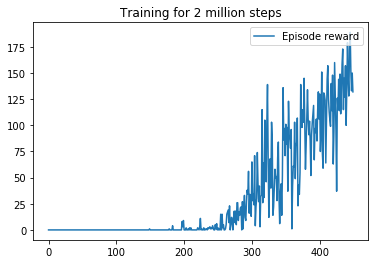

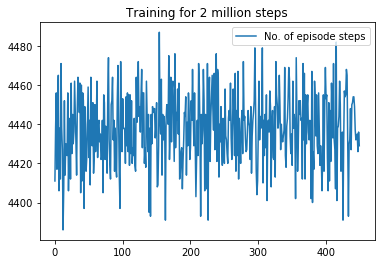

In [18]:
plt.plot(history2M.history['episode_reward'])
plt.title('Training for 2 million steps')
plt.legend(['Episode reward'], loc='upper right')
plt.show()

plt.plot(history2M.history['nb_episode_steps'])
plt.title('Training for 2 million steps')
plt.legend(['No. of episode steps'], loc='upper right')
plt.show()

#### 4. *Saving final weights*

In [20]:
dqn.save_weights('dqn_atari_Enduro.h5f', overwrite=True)

***
## <span style="color:teal"> Testing the model </span>

#### 1. Loading the weights for testing
We are here loading the best weights found during the second training of the model in order to test our model and its afficiency.

In [21]:
dqn.load_weights('dqn_atari_Enduro.h5f')

#### 2. Resetting the environment for testing
Here is the result found for a simulation on 2 episodes. An uncertainty is still there as we can see with the differences in rewards and steps. The best reward is logically attributed to the episode where the more steps were done.

In [22]:
env.reset()
dqn.test(env, nb_episodes=2, visualize=True)

Testing for 2 episodes ...
Episode 1: reward: 167.000, steps: 4475
Episode 2: reward: 148.000, steps: 4455


In [23]:
env.close()

***
## <span style="color:teal"> Analysis of the gamma factor </span>
***Gamma*** is the discount rate used as actuation factor in Q-learning. It determines the importance of future rewards. If that factor is too cloose of 0, the agent can't clearly see what would happen in the future and limits its knowledge to the current rewards. If that factor is too close to 1, the agent will have no memory of the past because he will only focus on the future. An interesting gamma should be bigger than 0.5 but less than 1, the standard gamma used in Q-learning and in the various solutions studied is a gamma equals to 0.99 which will maximize the focus on the future while still having data (even if limited) on the past.
<br><br> It is interesting to note that the agent starts improving the score when the ***epsilon*** has dropped to the minimum value. This is expected, since the agent would then start acting greedily most of the time, taking the action that has the higher state-action value.

***
## <span style="color:teal"> Sources </span> 
<ul>
    <li>https://github.com/v2-dev/Enduro-DQN</li>
    <li>https://github.com/matrixBT/DQN-Atari-Enduro</li>
    <li>https://github.com/markcutajar/atari-dqn</li>
    <li>https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf</li>
    <li>https://fse.studenttheses.ub.rug.nl/20812/1/AI_BA_2019_DANIELBICK.pdf</li>
    <li>https://www.efavdb.com/dqn</li>
    <li>https://markcutajar.com/blog/atari-enduro-dqn/</li>
    <li>https://in.mathworks.com/matlabcentral/profile/authors/10083740-bhartendu?&detail=fileexchange</li>
    <li>https://paperswithcode.com/method/dqn#:~:text=A%20DQN%2C%20or%20Deep%20Q,each%20action%20as%20an%20output.</li>
    <li>https://www.tensorflow.org/guide/keras/save_and_serialize</li>
</ul>